In [76]:
import config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime

# Functions

In [77]:
def drop_unnamedcolumn(df):
    df = df.loc[:, ~df.columns.str.contains('Unnamed')]
    return df

def get_nan_values(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    nan_summary = df.isna().sum()

    print("Columns with NaN values: ", nan_columns)
    print()
    print("NaN values per column:")
    print(nan_summary[nan_summary > 0].sort_values(ascending=False))
    return nan_columns

def check_duplicate_rows(df, column = 'record_id'):
    dupl_recordid = pd.DataFrame(df[column].value_counts().reset_index())
    dupl_recordid_l = list(dupl_recordid[dupl_recordid['count']>1][column])

    #TODO: add logic to delete duplicates, where the entire row is the same and 
    # call out the duplicates that are not the same

    if len(dupl_recordid_l)>0:
        dupl_rows = df[df[column].isin(dupl_recordid_l)].sort_values(by=column)

        print(f"Duplicate rows based on {column}:")
        display(dupl_rows)
        return dupl_rows
    else:
        print(f"No duplicate rows based on {column}.")
        return None
    
def investigate_data(df, save_path = None, save_name = None):
    df_descr = df.describe(include='all')

    if save_path:
        if save_name is None:
            print("No save name provided!")
            return
        save_path = os.path.join(save_path, f"{save_name}_description.csv")
        df_descr.to_csv(save_path, index=True, mode='x')
        print(f"Data description saved to {save_path}")
        print()
    
    max_count = df_descr.loc['count'].max()

    for col in df_descr.columns:
        if df_descr[col]['count'] < max_count:
            print(f"Column '{col}' has missing values: {df_descr[col]['count']} out of {max_count}")
    print()
    nan_columns = get_nan_values(df)

    if len(nan_columns) > 0:
        nan_df = df[df.isnull().any(axis=1)]
        nan_patient_id = nan_df['record_id'].unique()
        display(nan_df)
        print()
        _ = check_duplicate_rows(df, column='record_id')
        return nan_patient_id
    else:
        _ = check_duplicate_rows(df, column='record_id')
        
def plot_hist(df, column, title = None, xlabel = None, y_label = "Frequency", stat = 'frequency', figsize=(10, 6), hue= None, multiple='dodge', bins = 30, kde=False):
    plt.figure(figsize=figsize)
    if hue is None:
        sns.histplot(df[column], bins=bins, stat=stat, kde=kde)
    else:
        sns.histplot(data=df, x = column, bins=bins, stat=stat, hue = hue, multiple=multiple, kde=kde)
    plt.title(title if title else f"Distribution of {column}")
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(y_label)
    plt.show()

def plot_violin(df, column, title = None, xlabel = None, y_label = "Frequency", figsize=(10, 6), hue= 'gender'):
    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x = column, hue=hue)
    plt.title(title if title else f"Distribution of {column}")
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(y_label)
    plt.show()

In [78]:
today = datetime.date.today()

base_dir = config.RAW_DATA_PATH
proc_dir = config.PROC_DATA_PATH
save_dir = os.path.join(proc_dir, f"{today}_data_exploration")
os.makedirs(save_dir, exist_ok=True)

first_leg = "inmodi_data_first_visit.csv"
second_leg = "inmodi_data_second_visit.csv"

df_first = pd.read_csv(os.path.join(base_dir, first_leg), sep=",")
df_second = pd.read_csv(os.path.join(base_dir, second_leg), sep=",")

#TODO: import newest KL scores

# Data Cleaning

In [79]:
# remove unnamed columns
try:
    df_first = drop_unnamedcolumn(df_first)
    df_second = drop_unnamedcolumn(df_second)
except Exception as e:
    print(f"Error dropping unnamed columns: {e}")

In [80]:
print("Columns in first visit data:")
print(df_first.columns.tolist())

print("\nColumns in second visit data:")
print(df_second.columns.tolist())

Columns in first visit data:
['record_id', 'age', 'ce_height', 'ce_weight', 'ce_bmi', 'ce_fm', 'ce_pain_r', 'ce_pain_l', 'gender', 'COMI_score', 'OKS_score', 'UCLA_score', 'FJS_score', 'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport', 'KOOS_adl', 'KOOS_qol', 'rx_ap_kl_left', 'rx_ap_kl_right']

Columns in second visit data:
['record_id', 'age', 'ce_height', 'ce_weight', 'ce_bmi', 'ce_fm', 'ce_pain_r', 'ce_pain_l', 'gender', 'OKS_score', 'UCLA_score', 'FJS_score', 'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport', 'KOOS_adl', 'KOOS_qol']


## Missing Values & Duplicates

In [81]:
df_first_nanids = investigate_data(df_first) #save_path=save_dir, save_name="inmodi_data_first_visit"

Column 'ce_fm' has missing values: 119.0 out of 122
Column 'ce_pain_r' has missing values: 121.0 out of 122
Column 'ce_pain_l' has missing values: 121.0 out of 122
Column 'COMI_score' has missing values: 119.0 out of 122
Column 'UCLA_score' has missing values: 120.0 out of 122
Column 'KOOS_pain' has missing values: 117.0 out of 122
Column 'KOOS_symptoms' has missing values: 117.0 out of 122
Column 'KOOS_sport' has missing values: 117.0 out of 122
Column 'KOOS_adl' has missing values: 117.0 out of 122
Column 'KOOS_qol' has missing values: 117.0 out of 122
Column 'rx_ap_kl_left' has missing values: 120.0 out of 122

Columns with NaN values:  ['ce_fm', 'ce_pain_r', 'ce_pain_l', 'COMI_score', 'UCLA_score', 'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport', 'KOOS_adl', 'KOOS_qol', 'rx_ap_kl_left']

NaN values per column:
KOOS_adl         5
KOOS_pain        5
KOOS_symptoms    5
KOOS_qol         5
KOOS_sport       5
ce_fm            3
COMI_score       3
UCLA_score       2
rx_ap_kl_left    2
ce_pain_

,record_id,age,ce_height,ce_weight,ce_bmi,ce_fm,ce_pain_r,ce_pain_l,gender,COMI_score,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol,rx_ap_kl_left,rx_ap_kl_right
12,IM0016,42,176.0,84.0,27.1,NaN,0.0,0.0,male,0.00,48,5.0,0.000000,100.0,71.0,100.0,100.0,100.0,0.0,0
68,IM2013,50,183.0,83.0,24.8,NaN,0.0,0.0,male,0.00,48,10.0,4.166667,100.0,68.0,100.0,100.0,100.0,0.0,1
83,IM2501,42,179.0,88.2,27.5,23.6,2.0,0.0,male,8.65,0,NaN,-25.000000,NaN,NaN,NaN,NaN,NaN,0.0,1
97,IM2590,45,179.5,83.7,26.0,NaN,0.0,1.0,male,4.80,0,NaN,-25.000000,NaN,NaN,NaN,NaN,NaN,0.0,0
102,IM3000,69,169.0,77.0,27.0,40.3,0.0,3.0,female,4.65,0,6.0,-25.000000,NaN,NaN,NaN,NaN,NaN,2.0,2
103,IM3002,67,160.0,61.3,23.9,37.5,1.0,4.0,female,NaN,32,6.0,64.583333,61.0,36.0,30.0,66.0,25.0,3.0,2
105,IM3004,48,169.0,78.1,27.3,43.0,2.0,8.0,female,7.55,0,3.0,-25.000000,NaN,NaN,NaN,NaN,NaN,3.0,2
110,IM3010,62,180.0,101.4,31.3,30.4,7.0,0.0,male,8.75,0,3.0,-25.000000,NaN,NaN,NaN,NaN,NaN,3.0,2
113,IM3013,67,164.0,69.1,25.7,37.8,2.0,0.0,female,5.35,34,5.0,85.416667,72.0,32.0,0.0,60.0,12.0,NaN,2
117,IM3019,74,187.0,83.3,23.8,13.2,1.0,0.0,male,3.85,33,7.0,81.250000,69.0,39.0,30.0,68.0,31.0,NaN,4



Duplicate rows based on record_id:


,record_id,age,ce_height,ce_weight,ce_bmi,ce_fm,ce_pain_r,ce_pain_l,gender,COMI_score,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol,rx_ap_kl_left,rx_ap_kl_right
20,IM1005,42,175.0,82.9,27.1,26.5,0.0,0.0,male,0.0,48,6.0,0.0,100.0,71.0,100.0,100.0,100.0,0.0,1
21,IM1005,42,175.0,82.9,27.1,26.5,0.0,0.0,male,0.0,48,6.0,0.0,100.0,71.0,100.0,100.0,100.0,0.0,1


In [82]:
df_second_nanids = investigate_data(df_second) #save_path=save_dir, save_name="inmodi_data_second_visit"

Column 'ce_fm' has missing values: 107 out of 109
Column 'ce_pain_r' has missing values: 108.0 out of 109
Column 'ce_pain_l' has missing values: 108.0 out of 109
Column 'OKS_score' has missing values: 105.0 out of 109
Column 'UCLA_score' has missing values: 105.0 out of 109
Column 'FJS_score' has missing values: 105.0 out of 109
Column 'KOOS_pain' has missing values: 105.0 out of 109
Column 'KOOS_symptoms' has missing values: 105.0 out of 109
Column 'KOOS_sport' has missing values: 105.0 out of 109
Column 'KOOS_adl' has missing values: 105.0 out of 109
Column 'KOOS_qol' has missing values: 105.0 out of 109

Columns with NaN values:  ['ce_fm', 'ce_pain_r', 'ce_pain_l', 'OKS_score', 'UCLA_score', 'FJS_score', 'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport', 'KOOS_adl', 'KOOS_qol']

NaN values per column:
FJS_score        4
UCLA_score       4
OKS_score        4
KOOS_symptoms    4
KOOS_sport       4
KOOS_adl         4
KOOS_pain        4
KOOS_qol         4
ce_fm            2
ce_pain_l        1
c

,record_id,age,ce_height,ce_weight,ce_bmi,ce_fm,ce_pain_r,ce_pain_l,gender,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol
9,IM0013,36,169.0,62.5,21.9,27.8,0.0,6.0,female,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,IM0016,42,175.0,80.7,26.4,26.7,0.0,0.0,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,IM1005,42,175.0,85.0,27.8,NaN,0.0,0.0,male,48.0,6.0,0.000000,100.0,71.0,100.0,100.0,100.0
31,IM1046,47,185.0,79.0,23.1,20.1,0.0,0.0,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,IM2025,59,179.0,84.0,26.2,NaN,0.0,0.0,male,48.0,9.0,10.416667,97.0,61.0,95.0,100.0,94.0
90,IM2595,60,161.0,69.9,27.0,39,NaN,NaN,female,47.0,10.0,83.333333,92.0,61.0,75.0,75.0,50.0
99,IM3010,62,179.0,99.6,31.1,28.6,0.0,0.0,male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



No duplicate rows based on record_id.


For first leg, ce_fm, ce_pain_r, ce_pain_l, COMI_score, UCLA_score, KOOS scores and rx_ap_kl_left appear to possibly have missing values.

Also we have a unique record_id count of 121, but 122 record_ids (rows), therefore we might have duplicates.

## Quick Fix: Removing duplicates

In [83]:
print("Number of rows: ", len(df_first))
df_first = df_first.drop_duplicates(subset='record_id', keep='first')
print("Number of rows after dropping duplicates: ", len(df_first))

Number of rows:  122
Number of rows after dropping duplicates:  121


## Quick Fix: Fix Unique case

In [84]:
display(df_second[df_second['ce_fm']=='35.4, 26.4'])
outl_index = df_second[df_second['ce_fm']=='35.4, 26.4'].index

print(f"Location: {outl_index}")

,record_id,age,ce_height,ce_weight,ce_bmi,ce_fm,ce_pain_r,ce_pain_l,gender,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol
2,IM0004,55,152.0,54.7,23.7,"35.4, 26.4",0.0,0.0,female,48.0,7.0,2.083333,100.0,57.0,100.0,100.0,100.0


Location: Index([2], dtype='int64')


In [85]:
df_second.loc[outl_index, 'ce_fm'] = 35.4

In [86]:
display(df_second.iloc[outl_index])

,record_id,age,ce_height,ce_weight,ce_bmi,ce_fm,ce_pain_r,ce_pain_l,gender,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol
2,IM0004,55,152.0,54.7,23.7,35.4,0.0,0.0,female,48.0,7.0,2.083333,100.0,57.0,100.0,100.0,100.0


# Patient-Related Information

This includes patient information, such as age, bmi, body fat, pain and sex. Additionally, we will look at the aggregated questionnaire scores.

*Height and Weight was purposefully omitted in this part, since it is already covered in the BMI, which takes the height into account when evaluating the weight.*

**Columns Patient-Related Data**
* `record_id`: id column
* `age`: patient age (at time of study?)
* `ce_height`
* `ce_weight`
* `ce_bmi`
* `ce_fm`: body fat percentage (%)
* `ce_pain_r`: patient-reported pain (right leg)
* `ce_pain_l`: patient-reported pain (left leg)
* `gender`
* `COMI_score`: Core Outcome Measures Index
* `OKS_score`: Oxford Knee Score (12 Questions)
* `UCLA_score`: UCLA-Activity Index (1 Question)
* `FJS_score`: Forgotten Joint Score (12 Questions)
* `KOOS_pain`: Knee Injury and OA Outcome Score - Pain Section (9 Questions)
* `KOOS_symptoms`: Symptoms Section (7 Questions)
* `KOOS_sport`: Sport Section (5 Questions)
* `KOOS_adl`: Daily Activities Section (17 Questions)
* `KOOS_qol`: Quality of Living Section (4 Questions)
* `rx_ap_kl_left`: KL-Score (left leg)
* `rx_ap_kl_right`: KL-Score (right leg)

The various scores are aggregated in this dataset already.

In [87]:
df_first['visit'] = 1
df_second['visit'] = 2

pi = pd.concat([df_first, df_second], ignore_index=True)
print("Number of rows after concatenation: ", len(pi))

pi = pi.astype({'ce_fm':'float64'})
pi= pi.drop(columns=['rx_ap_kl_left', 'rx_ap_kl_right'])

# Columns that we will analyze
l_columns = ['age', 'ce_bmi', 'ce_fm',
       'gender', 'COMI_score', 'OKS_score',
       'UCLA_score', 'FJS_score', 'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport',
       'KOOS_adl', 'KOOS_qol']

Number of rows after concatenation:  230


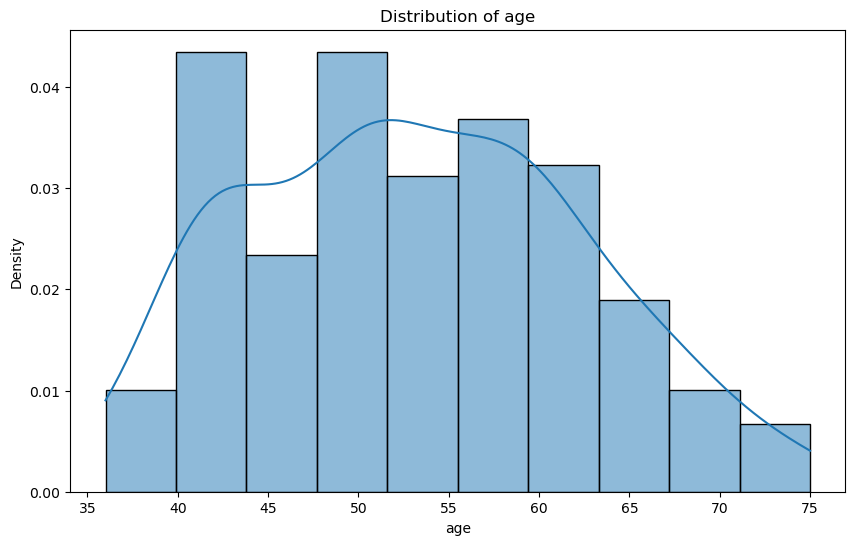

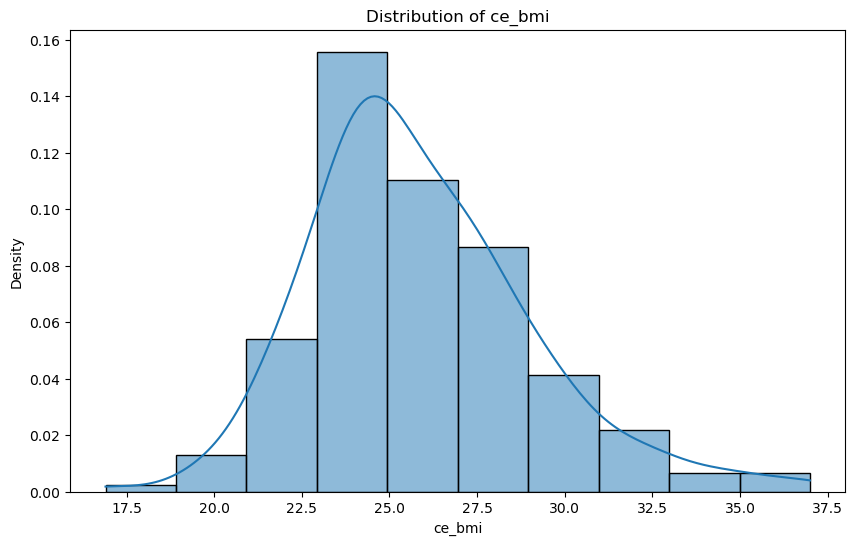

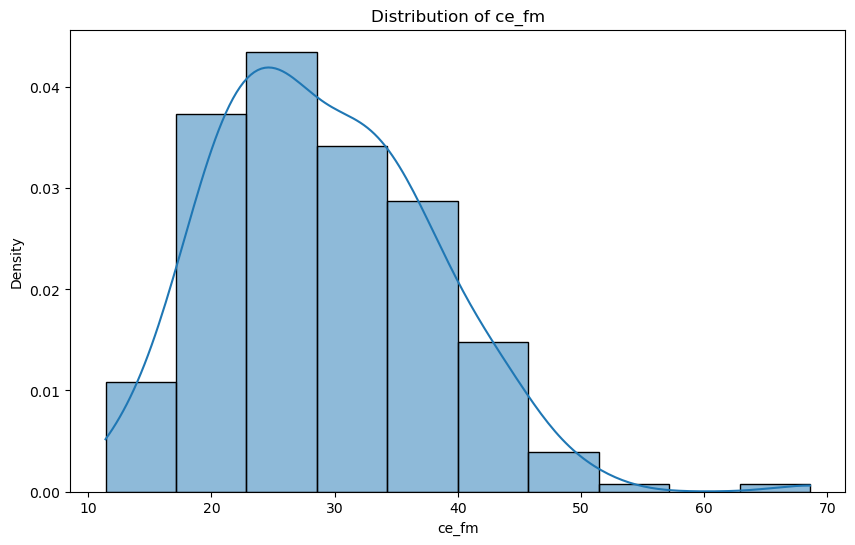

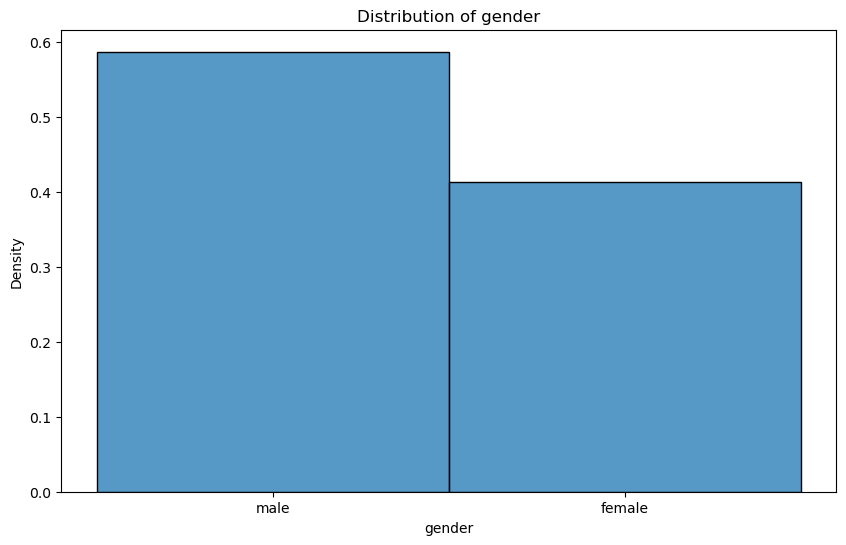

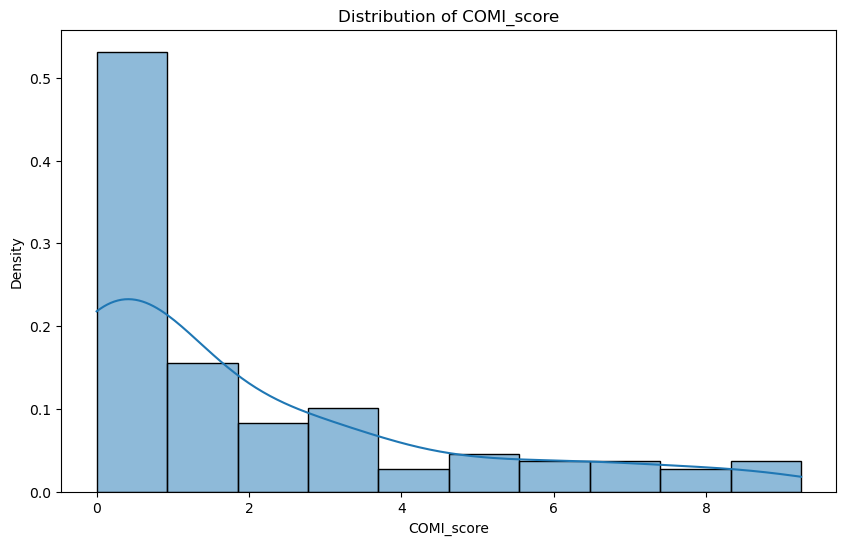

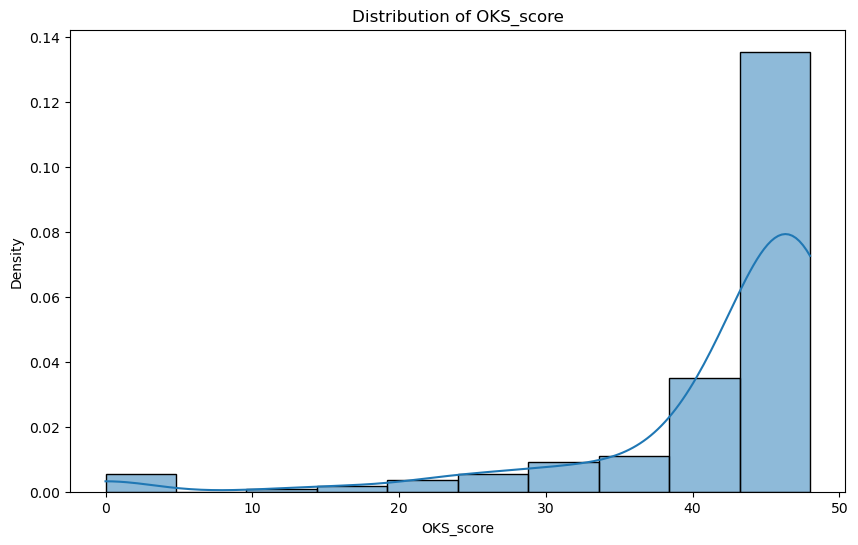

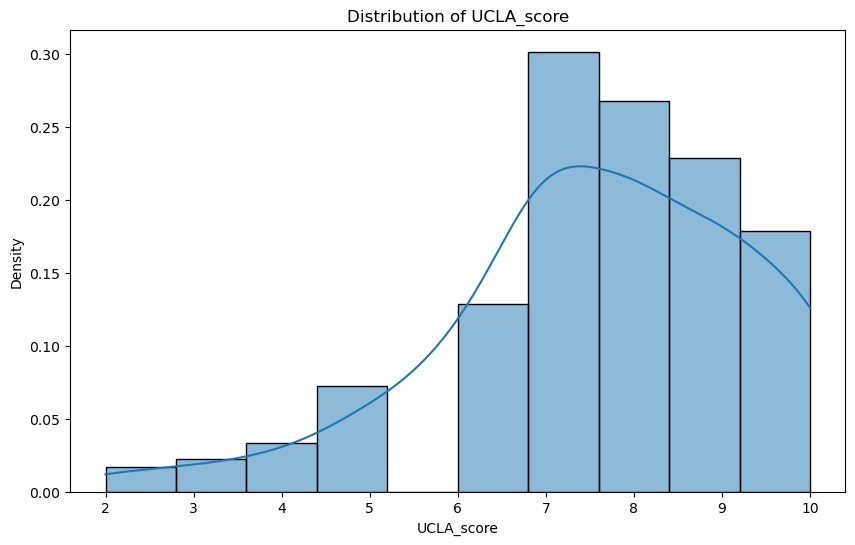

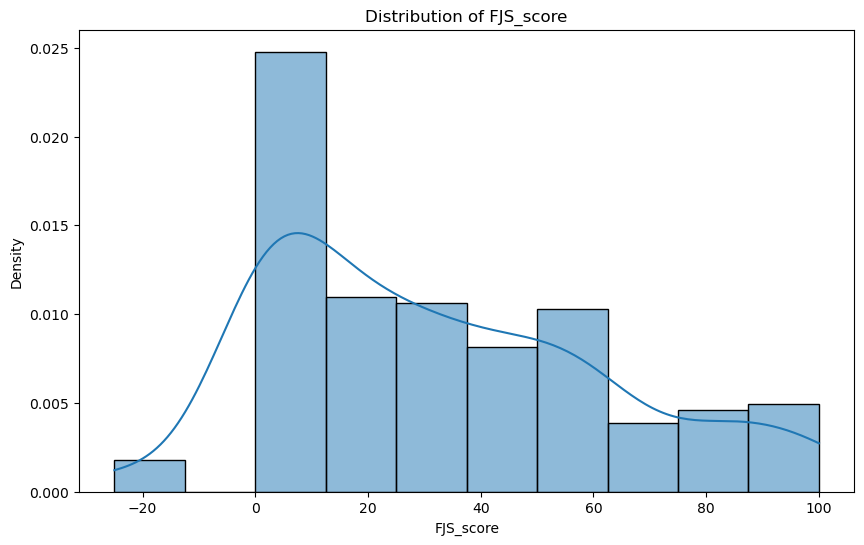

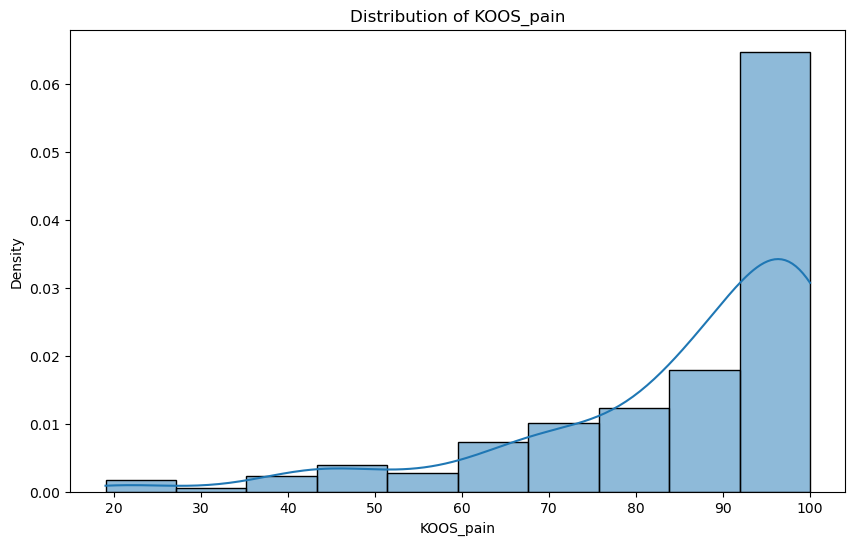

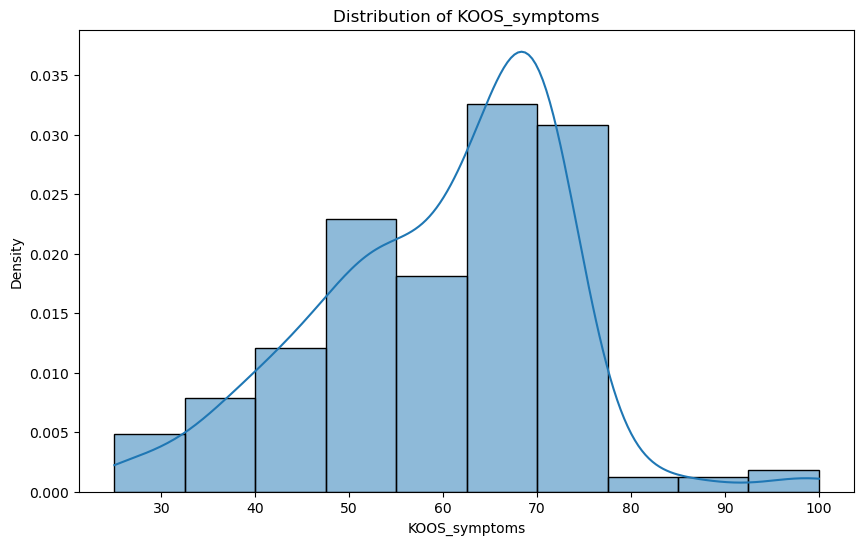

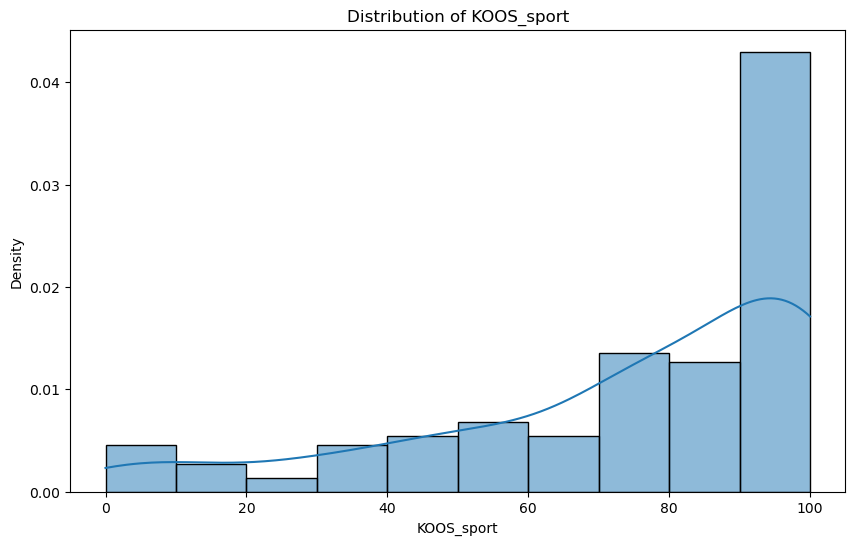

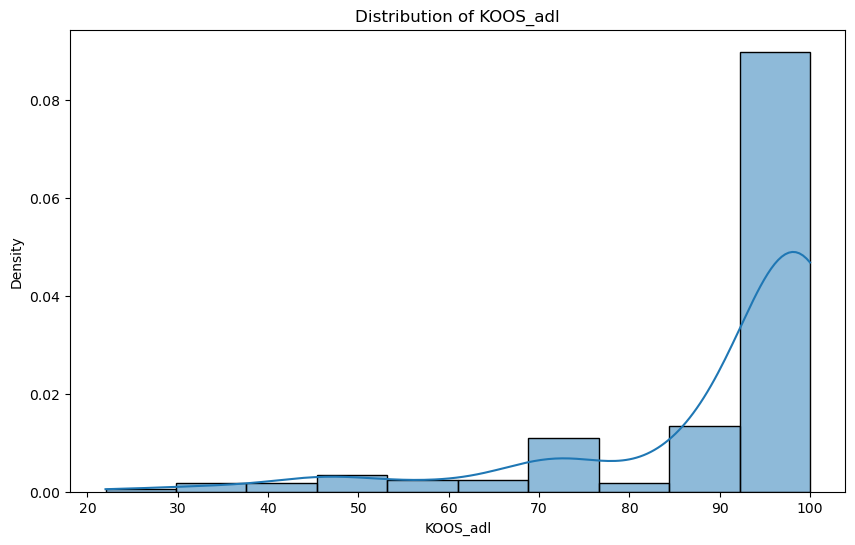

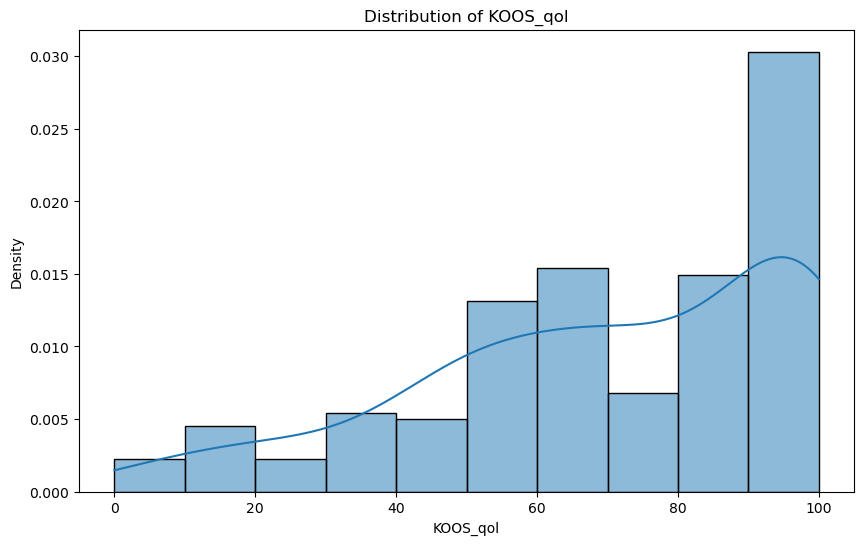

In [88]:
for col in l_columns:
    if col != 'gender':
        plot_hist(pi, col, figsize=(10, 6), stat='density', y_label = 'Density', bins=10, kde=True)
    elif col == 'gender':
        plot_hist(pi, col, figsize=(10, 6), stat='density', y_label = 'Density', bins=2, kde=False)

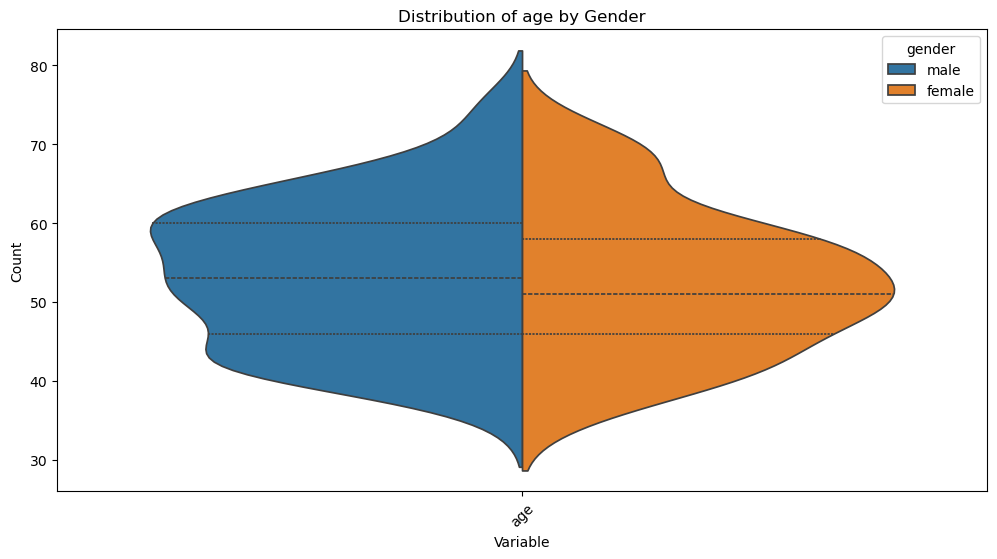

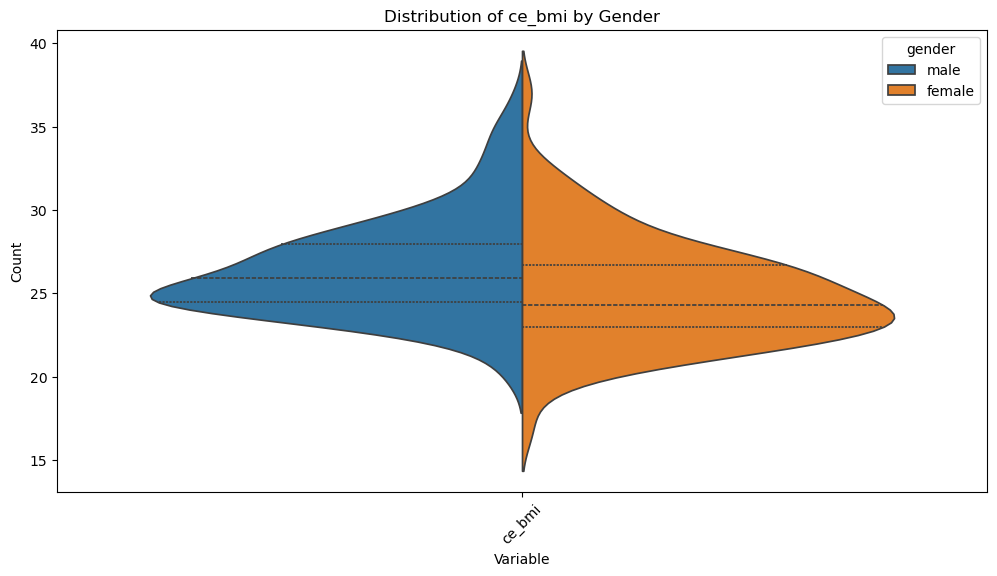

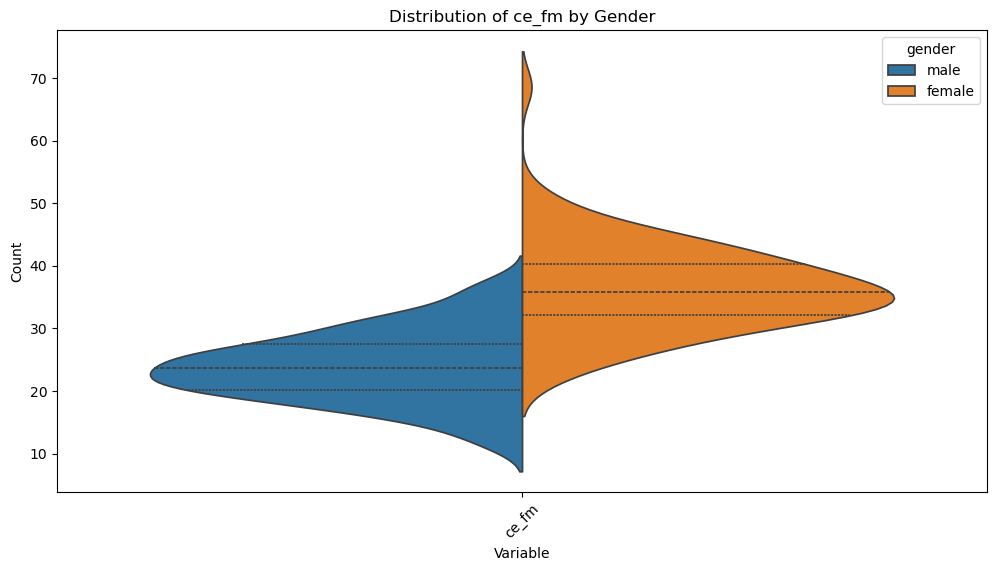

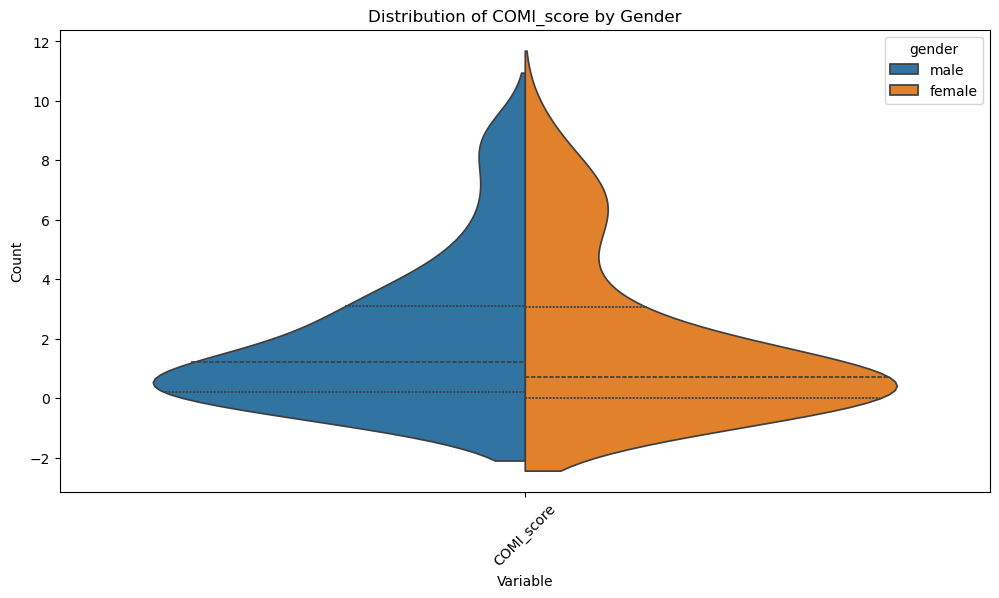

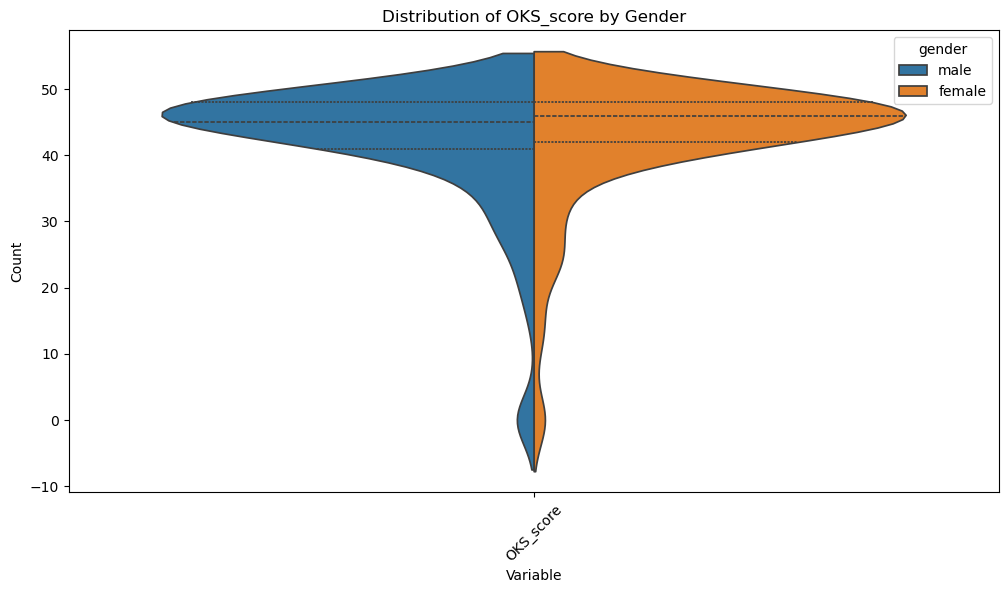

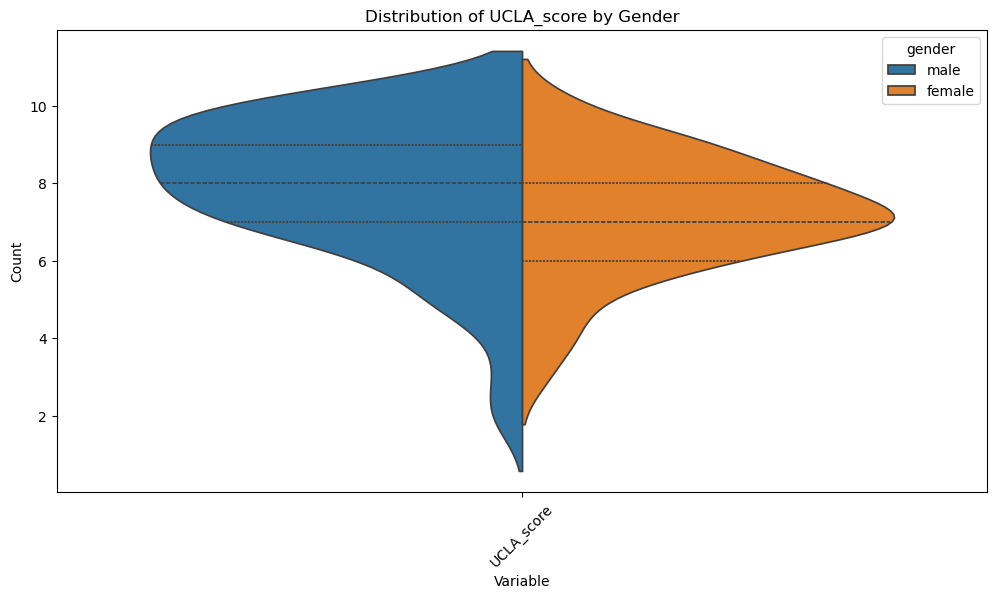

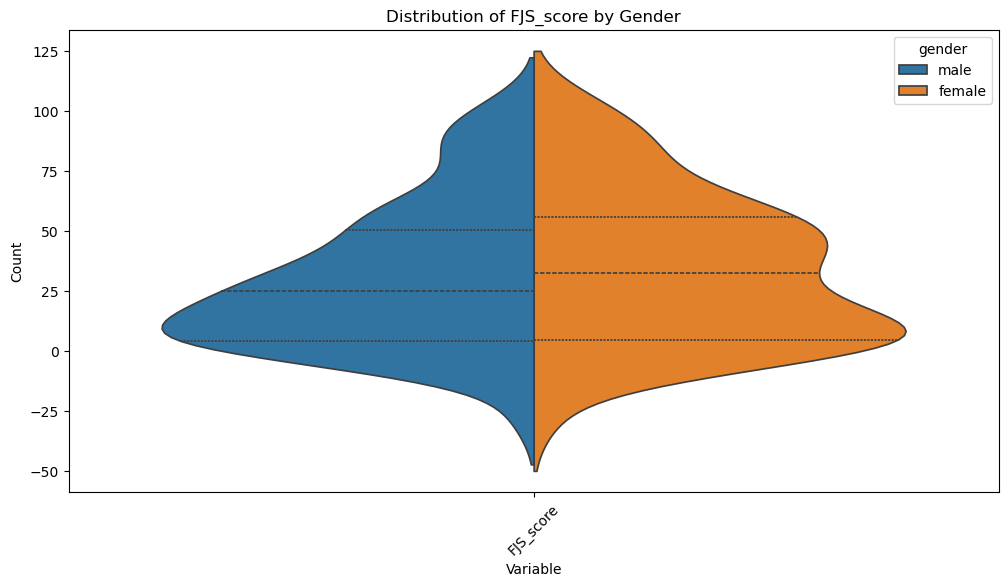

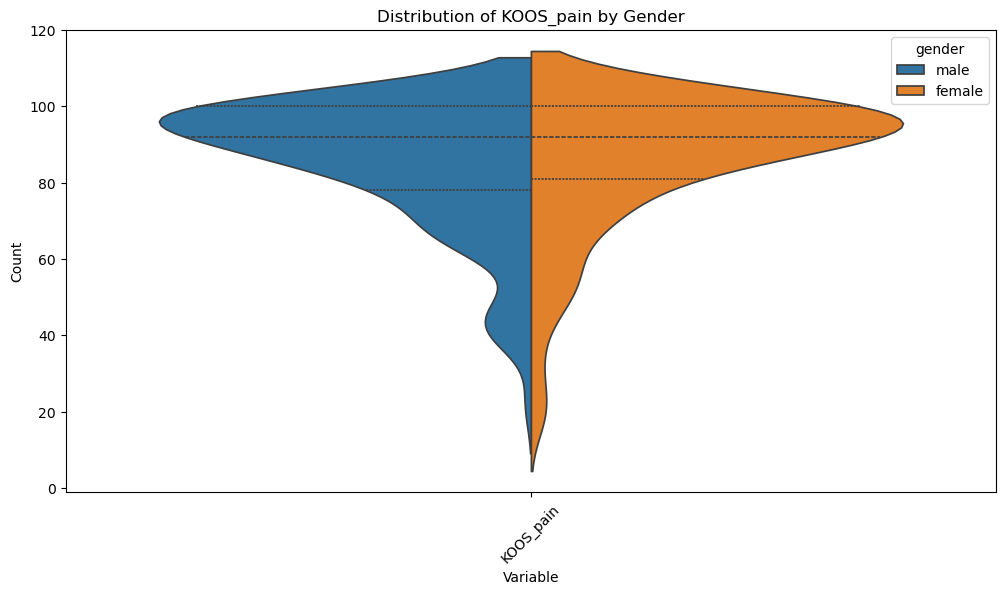

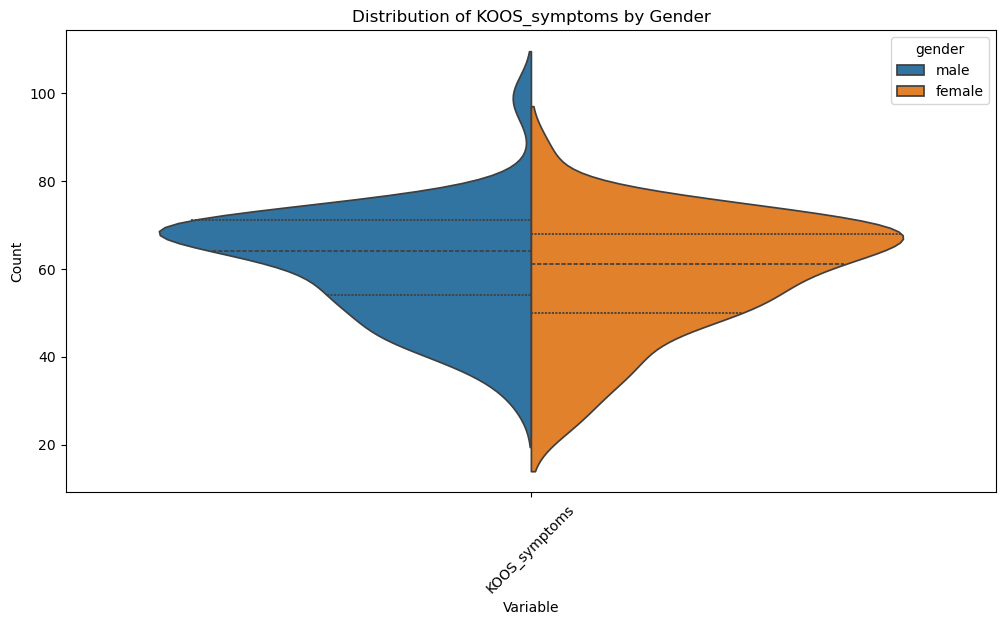

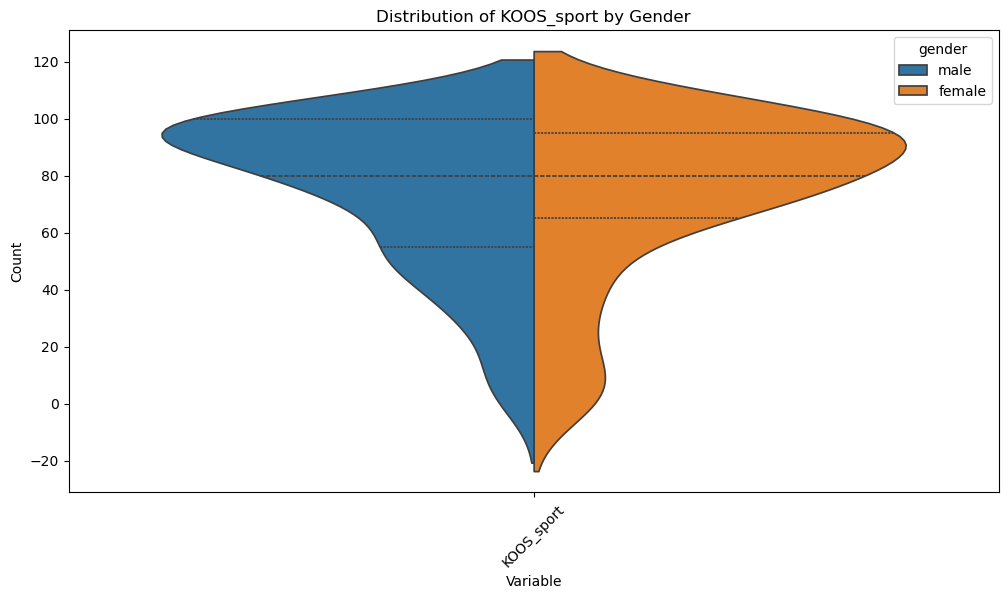

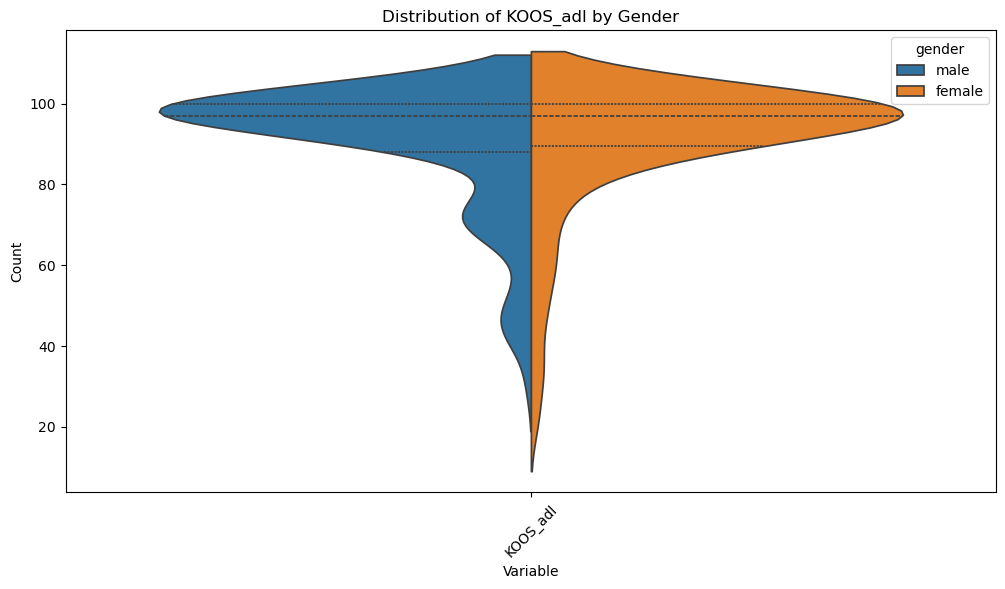

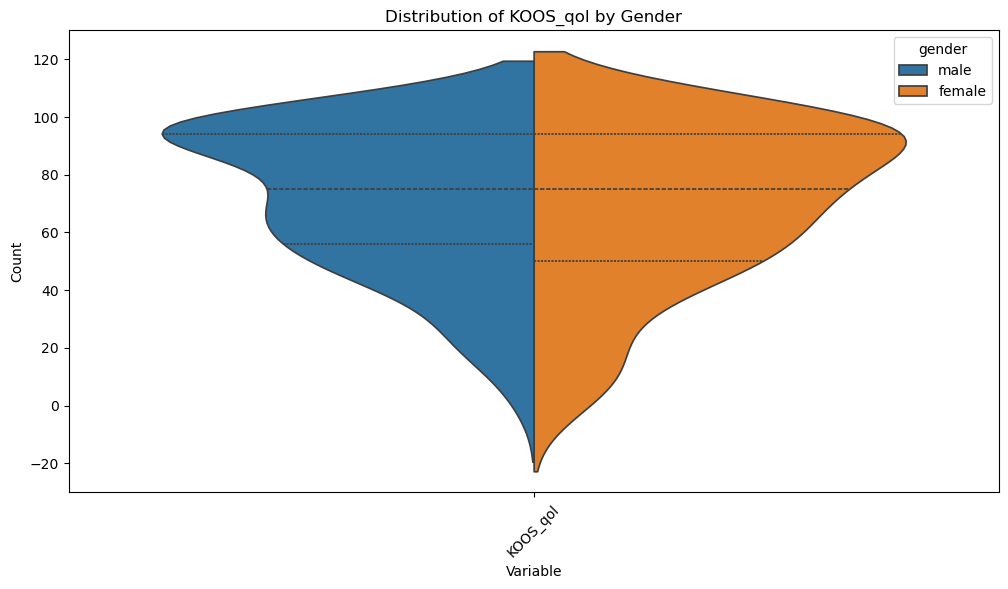

In [89]:
l_columns2 = ['age', 'ce_bmi', 'ce_fm',
        'COMI_score', 'OKS_score',
       'UCLA_score', 'FJS_score', 'KOOS_pain', 'KOOS_symptoms', 'KOOS_sport',
       'KOOS_adl', 'KOOS_qol']
for col in l_columns2:
    melted_df = pi.melt(id_vars='gender', value_vars=col, var_name='Variable', value_name='Count')
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=melted_df, x='Variable', y='Count', hue='gender', split=True, inner='quartile')
    plt.title(f"Distribution of {col} by Gender")
    plt.xticks(rotation=45)
    plt.show()

Pain for left and right leg needs to be concated, since we are interested in overall pain distribution, not specifically pain distribution of left and right leg.

### Patient-reported Pain

In [97]:
pain_df = pi.melt(id_vars=['record_id', 'visit'], value_vars=['ce_pain_l', 'ce_pain_r'], var_name='side', value_name='pain')

print()
print(f"Length of pivoted df: {len(pi)}")
print(f"Length of unpivoted df: {len(pain_df)}")

pain_df['side'] = pain_df['side'].str.replace('ce_pain_', '')

display(pain_df.head())



Length of pivoted df: 230
Length of unpivoted df: 460


,record_id,visit,side,pain
0,IM0001,1,l,0.0
1,IM0002,1,l,0.0
2,IM0004,1,l,0.0
3,IM0005,1,l,0.0
4,IM0008,1,l,0.0


In [101]:
pi2 = pi.drop(columns=['ce_pain_l', 'ce_pain_r'])

pi2 = pi2.drop_duplicates(subset=['record_id', 'visit'], keep='first')

print(f"PI2 DF shape: {pi2.shape}")

PI2 DF shape: (230, 17)


In [102]:
print(f"PI DF shape: {pi.shape}")
pi2 = pain_df.merge(pi2, on=['record_id', 'visit'], how='left')

print()
print(f"PI DF shape after merging pain data: {pi2.shape}")

PI DF shape: (230, 19)

PI DF shape after merging pain data: (460, 19)


In [103]:
display(pi2.head())

,record_id,visit,side,pain,age,ce_height,ce_weight,ce_bmi,ce_fm,gender,COMI_score,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol
0,IM0001,1,l,0.0,41,183.0,82.1,24.5,18.5,male,0.00,48.0,9.0,6.250000,100.0,100.0,100.0,100.0,100.0
1,IM0002,1,l,0.0,40,175.0,72.9,23.8,20.6,male,0.20,48.0,9.0,4.166667,100.0,68.0,100.0,100.0,100.0
2,IM0004,1,l,0.0,55,151.0,55.2,24.2,35.8,female,0.00,47.0,7.0,4.166667,100.0,61.0,95.0,100.0,100.0
3,IM0005,1,l,0.0,46,184.5,98.5,28.9,27.5,male,1.45,42.0,8.0,50.000000,86.0,46.0,70.0,97.0,81.0
4,IM0008,1,l,0.0,51,166.0,71.5,25.9,35.4,female,0.00,46.0,7.0,14.583333,92.0,68.0,90.0,100.0,88.0


In [111]:
count_recordid = pi2['record_id'].value_counts().reset_index()

print(f"These are the record ids with too many rows:")
display(count_recordid[count_recordid['count'] > 4])

These are the record ids with too many rows:


,record_id,count


In [112]:
pain_df['pain'].max()

np.float64(9.0)

*9 bins, because highest score is 9 and it is an int value.*

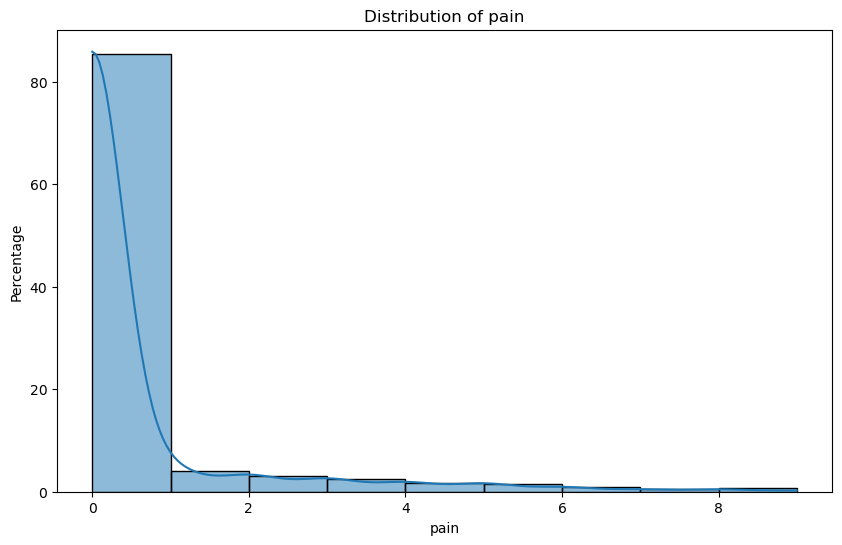

In [113]:
plot_hist(pain_df, column='pain', y_label='Percentage', stat='percent', 
          kde=True, bins=9)

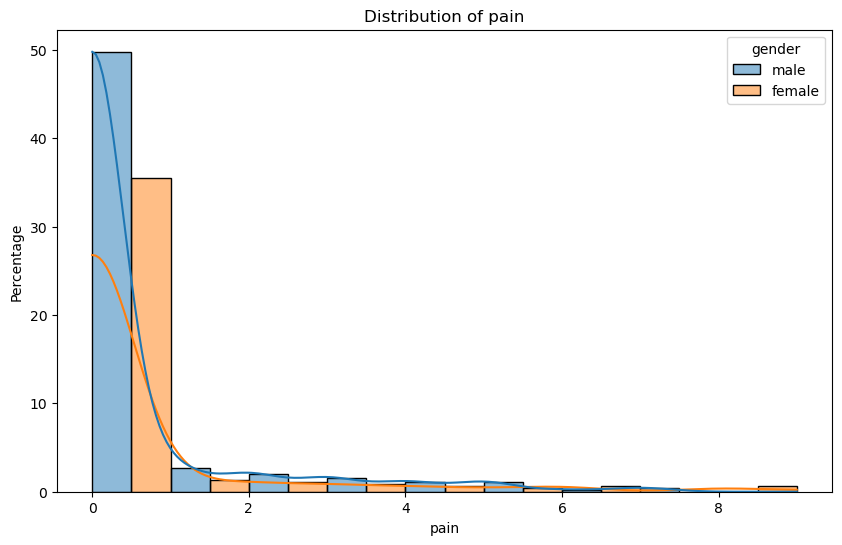

In [115]:
plot_hist(pi2, column='pain', y_label='Percentage', stat='percent', hue = 'gender',
          multiple='dodge', kde=True, bins=9)

In [116]:
pi2.head()

,record_id,visit,side,pain,age,ce_height,ce_weight,ce_bmi,ce_fm,gender,COMI_score,OKS_score,UCLA_score,FJS_score,KOOS_pain,KOOS_symptoms,KOOS_sport,KOOS_adl,KOOS_qol
0,IM0001,1,l,0.0,41,183.0,82.1,24.5,18.5,male,0.00,48.0,9.0,6.250000,100.0,100.0,100.0,100.0,100.0
1,IM0002,1,l,0.0,40,175.0,72.9,23.8,20.6,male,0.20,48.0,9.0,4.166667,100.0,68.0,100.0,100.0,100.0
2,IM0004,1,l,0.0,55,151.0,55.2,24.2,35.8,female,0.00,47.0,7.0,4.166667,100.0,61.0,95.0,100.0,100.0
3,IM0005,1,l,0.0,46,184.5,98.5,28.9,27.5,male,1.45,42.0,8.0,50.000000,86.0,46.0,70.0,97.0,81.0
4,IM0008,1,l,0.0,51,166.0,71.5,25.9,35.4,female,0.00,46.0,7.0,14.583333,92.0,68.0,90.0,100.0,88.0


In [117]:
#TODO: save cleaned pi version
pi.to_csv(os.path.join(save_dir, "inmodi_data_personalinformation.csv"), index=False)

#TODO: save cleaned unpivoted pi version
pi2.to_csv(os.path.join(save_dir, "inmodi_data_personalinformation_unpivoted.csv"), index=False)

# End of Code